# Processing Futures Data
This notebook loads the futures CSV, cleans it, and computes the implied rate (100 - Futures Price)

In [1]:
import pandas as pd
input_path = "data/raw_futures_monthly_1988_2030.csv"
processed_path = "data/processed_futures_monthly_1988_2030.csv"
print('Input path:', input_path)


Input path: data/raw_futures_monthly_1988_2030.csv


In [2]:
futures = pd.read_csv(input_path)
print('columns =', list(futures.columns))
futures.head()


columns = ['Exp Date', 'Symbol', 'Contract Name', 'Last', '52W High', '52W High Date', '52W Low', '52W Low Date', '52W %Chg', 'Time']


,Exp Date,Symbol,Contract Name,Last,52W High,52W High Date,52W Low,52W Low Date,52W %Chg,Time
0,1988-10-31,ZQV88,30-Day Fed Funds October 1988 Futures,91.71,91.79,1988-10-06,91.69,1988-10-20,-0.04%,1988-10-31
1,1988-11-30,ZQX88,30-Day Fed Funds November 1988 Futures,91.66,91.79,1988-10-14,91.55,1988-11-15,-0.04%,1988-11-30
2,1988-12-30,ZQZ88,30-Day Fed Funds December 1988 Futures,91.20,91.54,1988-11-01,90.89,1988-11-29,-0.15%,1988-12-30
3,1989-01-31,ZQF89,30-Day Fed Funds January 1989 Futures,90.88,91.59,1988-11-04,90.76,1988-12-16,-0.54%,1989-01-31
4,1989-02-28,ZQG89,30-Day Fed Funds February 1989 Futures,90.63,91.75,1988-11-01,90.62,1989-02-28,-0.90%,1989-02-28


# Clean the Data and Compute Implied Rate
Make sure all numerical entries are of type float and remove any unwanted signs (like %, +, etc.)

In [3]:
# cleaning and computing implied rate
import numpy as np
import re

def clean_numeric(x):
    # if nan, return that. If numeric, return float
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float,)):
        return float(x)

    # remove any %'s and commas
    s = str(x).strip()
    if s == '':
        return np.nan
    s = s.replace(',', '').replace('%','')

    # remove the +/- for '52W &Chg' and cast as a float
    m = re.search(r'[-+]?[0-9]*\.?[0-9]+', s)
    if m:
        try:
            return float(m.group(0))
        except:
            return np.nan
    return np.nan

# change naming for more intuitive use and clean the data
futures.rename(columns={'Last': 'futures_price', 'Exp Date': 'exp_date', '52W High': '52W_high', '52W Low': '52W_low', '52W %Chg': '52W_pct_chg'}, inplace=True)
to_clean = ['futures_price', '52W_high', '52W_low', '52W_pct_chg']
for col in to_clean:
    futures[col] = futures[col].apply(clean_numeric)

futures['exp_date'] = pd.to_datetime(futures['exp_date'], errors='coerce')


# sort by date
futures.sort_values('exp_date', inplace=True)

# compute implied rate and add it to dataframe
futures['implied_rate'] = 100.0 - futures['futures_price']


# Write Cleaned Data to CSV
Return a CSV with only the timestamp, futures price, and implied rate.
If we want to use other features

In [4]:
futures_to_csv = futures[['exp_date', '52W_high', '52W_low', '52W_pct_chg', 'futures_price', 'implied_rate']]
futures_to_csv.head()

,exp_date,52W_high,52W_low,52W_pct_chg,futures_price,implied_rate
0,1988-10-31,91.79,91.69,-0.04,91.71,8.29
1,1988-11-30,91.79,91.55,-0.04,91.66,8.34
2,1988-12-30,91.54,90.89,-0.15,91.20,8.80
3,1989-01-31,91.59,90.76,-0.54,90.88,9.12
4,1989-02-28,91.75,90.62,-0.90,90.63,9.37


In [5]:
futures_to_csv.to_csv(processed_path, index=False)

# Compare Historical Implied Rate vs. Actual Rate
The historical similarity between the implied and actual rate can be used as EDA/justification for why we think implied rate is a strong feature. If not, it at least is kinda cool. Implied rate is the market's expectation of the mean of the daily effective federal funds rate (EFFR) for a given month. EFFR data (effr.xlsx) is from NY Fed: https://www.newyorkfed.org/markets/reference-rates/effr.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Available Months for comparison (7/2000 - 10/2025): 289
Mean Abs. Error: 0.013
RMSE: 0.055
Correlation (implied vs realized): 0.9996


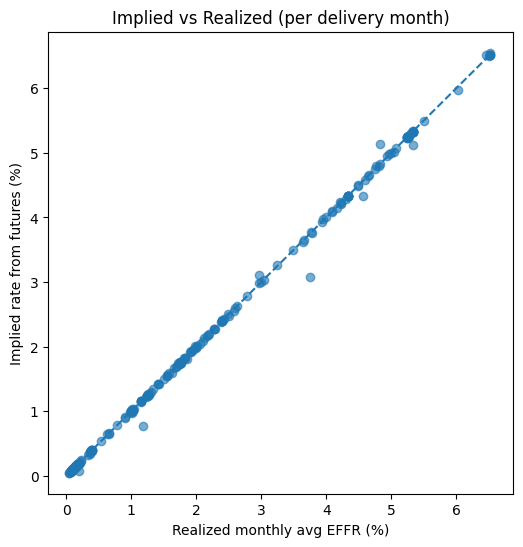

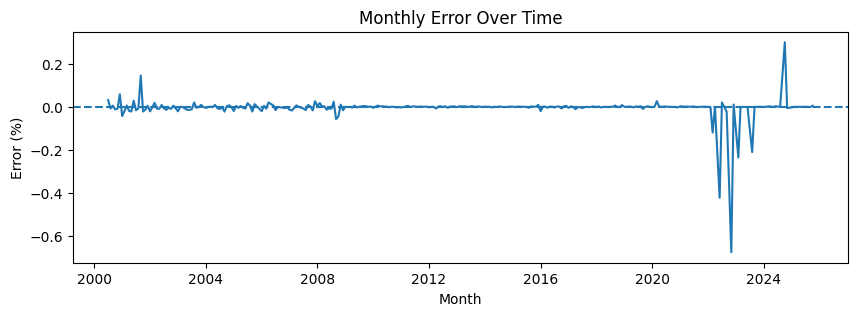

In [6]:
import numpy as np
import matplotlib.pyplot as plt

implied_col = 'implied_rate'
expdate_col = 'exp_date'
futures['exp_date'] = pd.to_datetime(futures[expdate_col])

# create a 'month' feature for ease of use
futures['month'] = futures['exp_date'].dt.to_period('M')

# get last price per month
repr_per_month = (futures.groupby('month', as_index=False).last()[['month', implied_col, expdate_col]])

# load realized daily EFFR data and compute monthly averages so we can compare with implied rate
local_effr_path = "data/effr.xlsx"
xls = pd.ExcelFile(local_effr_path)

tmp = xls.parse(xls.sheet_names[0])
effr = tmp[['Effective Date', 'Rate (%)']].copy()
effr.columns = ['Date', 'EFFR']
effr['Date'] = pd.to_datetime(effr['Date'])
effr['EFFR'] = pd.to_numeric(effr['EFFR'])


# compute realized monthly average EFFR (mean of daily within one month)
effr['month'] = effr['Date'].dt.to_period('M')
realized_monthly = effr.groupby('month', as_index=False)['EFFR'].mean()

# merge implied with realized monthly averages
merged = pd.merge(repr_per_month, realized_monthly)

# compute error and stats
merged['error_pct'] = merged['implied_rate'] - merged['EFFR']

mae  = merged['error_pct'].abs().mean()
rmse = np.sqrt((merged['error_pct']**2).mean())
corr = merged[['implied_rate','EFFR']].corr().iloc[0,1]

print(f"Available Months for comparison (7/2000 - 10/2025): {len(merged)}")
print(f"Mean Abs. Error: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Correlation (implied vs realized): {corr:.4f}")

# save and plot
merged.to_csv("data/futures_vs_realized_monthly.csv", index=False)

# scatterplot
plt.figure(figsize=(6,6))
plt.scatter(merged['EFFR'], merged['implied_rate'], alpha=0.6)
minv = min(merged['EFFR'].min(), merged['implied_rate'].min())
maxv = max(merged['EFFR'].max(), merged['implied_rate'].max())
plt.plot([minv,maxv],[minv,maxv], linestyle='--')   # 1:1 line
plt.xlabel('Realized monthly avg EFFR (%)')
plt.ylabel('Implied rate from futures (%)')
plt.title('Implied vs Realized (per delivery month)')
plt.show()

# error time series
plt.figure(figsize=(10,3))
plt.plot(merged['month'].dt.to_timestamp(), merged['error_pct'])
plt.axhline(0, linestyle='--')
plt.xlabel('Month')
plt.ylabel('Error (%)')
plt.title('Monthly Error Over Time')
plt.show()